# Best subset selection of Vespa ranking features

- toc: true 
- badges: true
- comments: true
- categories: [ranking features, vespa, feature selection, model selection]

In [1]:
# hide
%load_ext autoreload
%autoreload 2

## Load data collected from Vespa

The dataset used here were created by collecting ranking features from Vespa associated with the labelled data released by the round 3 of the TREC-CORD competition.

In [7]:
#hide
from pandas import read_msgpack

vespa_cord19 = read_msgpack("data/2020-05-27-subset-selection/training_features.msg")

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [31]:
vespa_cord19.head(2)

,topic_id,iteration,cord_uid,relevancy,query,query-rewrite,query-vector,question,narrative,fieldMatch(abstract),...,fieldLength(body_text),fieldLength(title),freshness(timestamp),nativeRank(abstract),nativeRank(abstract_t5),nativeRank(title),rawScore(specter_embedding),rawScore(abstract_embedding),rawScore(title_embedding),binary_relevance
0,1,0.5,010vptx3,2,coronavirus origin,coronavirus origin origin COVID-19 information...,"(0.28812721371650696, 1.558979868888855, 0.481...",what is the origin of COVID-19,seeking range of information about the SARS-Co...,0.111406,...,0,0,0,0,0,0,0,0,0,1
1,1,2.0,p0kv1pht,1,coronavirus origin,coronavirus origin origin COVID-19 information...,"(0.28812721371650696, 1.558979868888855, 0.481...",what is the origin of COVID-19,seeking range of information about the SARS-Co...,0.094629,...,0,0,0,0,0,0,0,0,0,1


There are 163 ranking features available. Below we print the first three as a sample.

In [34]:
features = [
    x for x in list(vespa_cord19.columns) if x not in [
        'topic_id', 'iteration', 'cord_uid', 'relevancy', 'binary_relevance', 'query', 
        'query-rewrite', 'query-vector', 'question', 'narrative'
    ]
]
print(len(features))
print(features[:3])

163
['fieldMatch(abstract)', 'fieldMatch(abstract).absoluteOccurrence', 'fieldMatch(abstract).absoluteProximity']


The original labelled data has three types of label: 0, 1 and 2. To simplify we will consider just two labels here. The document is either relevant (label = 1) or irrelevant (label = 0)

In [35]:
vespa_cord19["binary_relevance"] = vespa_cord19.apply(lambda row: 1 if row["relevancy"] > 0 else 0, axis=1)
vespa_cord19[['relevancy', 'binary_relevance']].head()

,relevancy,binary_relevance
0,2,1
1,1,1
2,2,1
3,0,0
4,0,0


## Model

We are going to fit logistic regressions with the objective of maximizing the log probability of the observed outcome.

In [12]:
from sklearn.linear_model import LogisticRegression
from statistics import mean

def compute_mean_realize_log_prob(model, X, Y):
    return mean([x[int(y)] for x, y in zip(model.predict_log_proba(X), Y)])
    
def fit_logistic_reg(X, Y):
    model = LogisticRegression(penalty='none', fit_intercept=True)
    model.fit(X, Y)
    realized_log_prob = compute_mean_realize_log_prob(model, X, Y)
    return realized_log_prob

## Subset selection routine

Give the high number of features, we can only apply the best subset selection algorithm up to three features. Instead of running one logistic regression for each feature combination, we will run 10 replications with smaller sampled datasets with 1.000 data points.

In [ ]:
#hide
if False:
    import itertools
    import pandas as pd
    from tqdm import tnrange, tqdm_notebook #Importing tqdm for the progress bar
    from tqdm.notebook import trange

    #Initialization variables
    log_probs, feature_list = [], []
    numb_features = []
    data_sample = []
    number_sample = 10
    number_points_per_sample = 1000
    max_number_features = min(3, len(features))

    for i in range(number_sample): 
        data = vespa_cord19.sample(n=number_points_per_sample, random_state=456)
        Y = data.binary_relevance
        X = data[features]

        #Looping over k = 1 to k = 11 features in X
        for k in trange(1,max_number_features + 1, desc = 'Loop...'):

            print(k)

            #Looping over all possible combinations: from 11 choose k
            for combo in itertools.combinations(X.columns,k):
                tmp_result = fit_logistic_reg(X[list(combo)],Y)   #Store temp result 
                log_probs.append(tmp_result)                    #Append lists
                feature_list.append(combo)
                numb_features.append(len(combo))   
                data_sample.append(i)

    #Store in DataFrame
    df = pd.DataFrame(
        {
            'data_sample': data_sample, 
            'numb_features': numb_features,
            'log_probs': log_probs,
            'features':feature_list
        }
    )
    df.to_csv("data/2020-05-27-subset-selection/best_subset_selection_sampling_10_points_1000_features_3.csv", index=False)

In [ ]:
import itertools
import pandas as pd
from tqdm import tnrange, tqdm_notebook #Importing tqdm for the progress bar
from tqdm.notebook import trange

#Initialization variables
log_probs, feature_list = [], []
numb_features = []
data_sample = []
number_sample = 10
number_points_per_sample = 1000
max_number_features = min(3, len(features))

for i in range(number_sample): 
    data = vespa_cord19.sample(n=number_points_per_sample, random_state=456)
    Y = data.binary_relevance
    X = data[features]

    #Looping over k = 1 to k = 11 features in X
    for k in trange(1,max_number_features + 1, desc = 'Loop...'):

        print(k)

        #Looping over all possible combinations: from 11 choose k
        for combo in itertools.combinations(X.columns,k):
            tmp_result = fit_logistic_reg(X[list(combo)],Y)   #Store temp result 
            log_probs.append(tmp_result)                    #Append lists
            feature_list.append(combo)
            numb_features.append(len(combo))   
            data_sample.append(i)

#Store in DataFrame
df = pd.DataFrame(
    {
        'data_sample': data_sample, 
        'numb_features': numb_features,
        'log_probs': log_probs,
        'features':feature_list
    }
)

In [36]:
# hide
from pandas import read_csv

df = read_csv("data/2020-05-27-subset-selection/best_subset_selection_sampling_10_points_1000_features_3.csv")

## Analyze results

### fine-grained results

Even with the limitation of checking at most 3 features we end up running more than 7 million logistic regressions to obtain the results presented here.

In [16]:
df

,data_sample,numb_features,log_probs,features
0,0,1,-0.577166,"(fieldMatch(abstract),)"
1,0,1,-0.584612,"(fieldMatch(abstract).absoluteOccurrence,)"
2,0,1,-0.589084,"(fieldMatch(abstract).absoluteProximity,)"
3,0,1,-0.563372,"(fieldMatch(abstract).completeness,)"
4,0,1,-0.589136,"(fieldMatch(abstract).degradedMatches,)"
...,...,...,...,...
7219265,9,3,-0.589136,"(nativeRank(abstract_t5), rawScore(abstract_em..."
7219266,9,3,-0.589136,"(nativeRank(title), rawScore(specter_embedding..."
7219267,9,3,-0.589136,"(nativeRank(title), rawScore(specter_embedding..."
7219268,9,3,-0.589136,"(nativeRank(title), rawScore(abstract_embeddin..."


### Average across data samples

We can now average the results across the 10 replications we runned for each combination.

In [17]:
average_df = df.groupby(['numb_features', 'features'], as_index=False).mean()
average_df

,numb_features,features,data_sample,log_probs
0,1,"(attribute(has_full_text),)",4.5,-0.589136
1,1,"(bm25(abstract),)",4.5,-0.560556
2,1,"(bm25(abstract_t5),)",4.5,-0.574475
3,1,"(bm25(body_text),)",4.5,-0.587452
4,1,"(bm25(title),)",4.5,-0.558449
...,...,...,...,...
721922,3,"(textSimilarity(title).score, nativeRank(title...",4.5,-0.576275
721923,3,"(textSimilarity(title).score, nativeRank(title...",4.5,-0.576275
721924,3,"(textSimilarity(title).score, rawScore(abstrac...",4.5,-0.576275
721925,3,"(textSimilarity(title).score, rawScore(specter...",4.5,-0.576275


### Plot average results across data samples

In [18]:
average_df['max_log_probs'] = df.groupby('numb_features')['log_probs'].transform(max)
average_df

,numb_features,features,data_sample,log_probs,max_log_probs
0,1,"(attribute(has_full_text),)",4.5,-0.589136,-0.558449
1,1,"(bm25(abstract),)",4.5,-0.560556,-0.558449
2,1,"(bm25(abstract_t5),)",4.5,-0.574475,-0.558449
3,1,"(bm25(body_text),)",4.5,-0.587452,-0.558449
4,1,"(bm25(title),)",4.5,-0.558449,-0.558449
...,...,...,...,...,...
721922,3,"(textSimilarity(title).score, nativeRank(title...",4.5,-0.576275,-0.534266
721923,3,"(textSimilarity(title).score, nativeRank(title...",4.5,-0.576275,-0.534266
721924,3,"(textSimilarity(title).score, rawScore(abstrac...",4.5,-0.576275,-0.534266
721925,3,"(textSimilarity(title).score, rawScore(specter...",4.5,-0.576275,-0.534266


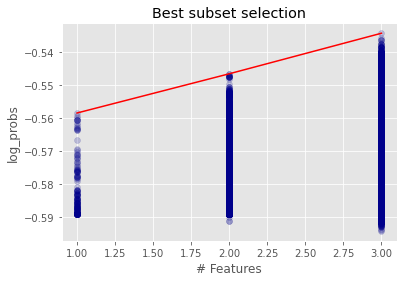

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

plt.scatter(average_df.numb_features,average_df.log_probs, alpha = .2, color = 'darkblue')
plt.xlabel('# Features')
plt.ylabel('log_probs')
plt.title('Best subset selection')
plt.plot(average_df.numb_features,average_df.max_log_probs, color = 'r', label = 'Best subset')

plt.show()

### Display the best features for each model size

In [25]:
average_df_max = average_df.sort_values('log_probs', ascending=False).drop_duplicates(['numb_features']).sort_values('numb_features')

In [28]:
for f in average_df_max.features:
    print(f)

('bm25(title)',)
('textSimilarity(title).queryCoverage', 'bm25(abstract)')
('textSimilarity(abstract).proximity', 'textSimilarity(title).queryCoverage', 'bm25(abstract)')
